# Testing DrugAgent and DrugEnv APIs

Load data.

In [2]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore') 

import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Load assays and utility functions.

In [3]:
import os

def get_tcp_objectives():

    dockstring_dir = f'{path}/dockstring_targets/'
    files = os.listdir(dockstring_dir)
    configs = sorted([f for f in files if 'conf' in f])
    targets = sorted([f for f in files if 'target' in f])

    idx = 0
    with open(dockstring_dir + configs[idx], 'r') as f:
        config_ = f.readlines()
        config_ = [c.replace('\n', '') for c in config_]
        config_ = [c.split(' = ') for c in config_ if c]
        config_ = {c[0]: float(c[1]) for c in config_}

    target = targets[idx]
    name = target.split('_')[0]

    config_.update({
        'size_x': 22.5,
        'size_y': 22.5,
        'size_z': 22.5,
    })

    from dgym.envs.oracle import \
        DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle
    from dgym.envs.utility import ClassicUtilityFunction

    config = {
        'search_mode': 'detailed',
        'scoring': 'vina',
        'seed': 5,
        **config_
    }

    pIC50_oracle = DockingOracle(
        f'{name} pIC50',
        receptor_path=f'{path}/dockstring_targets/{name}_target.pdbqt',
        config=config
    )
    log_P_oracle = RDKitOracle('Log P', descriptor='MolLogP')
    log_S_oracle = CatBoostOracle(
        'Log S', path='../dgym/envs/models/aqsolcb.model')
    
    return pIC50_oracle, log_P_oracle, log_S_oracle

In [4]:
from dgym.envs.utility import ClassicUtilityFunction, MultipleUtilityFunction

# Get objectives
pIC50_oracle, log_P_oracle, log_S_oracle = get_tcp_objectives()

# Define utility functions
pIC50_utility = ClassicUtilityFunction(
    pIC50_oracle, ideal=(9.5, 13), acceptable=(8, 13))
log_P_utility = ClassicUtilityFunction(
    log_P_oracle, ideal=(0.5, 1.85), acceptable=(-0.5, 3.5))
log_S_utility = ClassicUtilityFunction(
    log_S_oracle, ideal=(-3, 1), acceptable=(-4, 1))

# Assemble assays and surrogate models
assays = [
    pIC50_oracle,
    log_P_oracle,
    log_S_oracle,
    pIC50_oracle.surrogate(sigma=1.0),
    log_P_oracle.surrogate(sigma=1.0),
    log_S_oracle.surrogate(sigma=1.0),
]

# Environment tolerates acceptable ADMET
from copy import deepcopy
utility_agent = MultipleUtilityFunction(
    utility_functions = [pIC50_utility, log_P_utility, log_S_utility],
    weights = [0.8, 0.1, 0.1]
)
utility_env = deepcopy(utility_agent)
utility_env.utility_functions[1].ideal = utility_env.utility_functions[1].acceptable
utility_env.utility_functions[2].ideal = utility_env.utility_functions[2].acceptable

Instantiate designer.

In [5]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [6]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
library = dg.MoleculeCollection(initial_molecules).update_annotations()

Instantiate Environment and Agent.

In [7]:
from dgym.envs import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

drug_env = DrugEnv(
    designer = designer,
    library = library,
    assays = assays,
    utility_function = utility_env
)

# Construct sequence
design_grow = {'name': 'design', 'batch_size': 5, 'parameters': {'temperature': 1.0, 'strategy': 'grow', 'size': 8}}
design_replace = {'name': 'design', 'batch_size': 5, 'parameters': {'temperature': 1.0, 'strategy': 'replace', 'size': 8}}

make = {'name': 'make', 'batch_size': 40}
test = {'name': ['ABL1 pIC50', 'Log S', 'Log P'], 'batch_size': 8}
test_surrogate = {'name': ['Noisy ABL1 pIC50', 'Noisy Log S', 'Noisy Log P'], 'batch_size': 40}
design_and_score = [design_replace, test_surrogate]

sequence = [*(design_and_score * 1), design_grow, test_surrogate, make, test]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    exploration_strategy = EpsilonGreedy(epsilon=0.0),
    utility_function = utility_agent
)

In [8]:
def display_best():
    import numpy as np
    utilities = drug_env.utility_function(
        observations, use_precomputed=True, method='average')
    for obs, utility in zip(observations, utilities):
        obs.update_annotations({'utility': utility})
    tested = observations.tested
    if tested:
        best_tested = (
            tested
            .annotations
            .sort_values('utility', ascending=False)
            [['ABL1 pIC50', 'Log S', 'Log P', 'utility']]
            .head()
        )
        display(best_tested)

In [9]:
import json
from tqdm.notebook import tqdm

drug_agent.reset()
observations, _ = drug_env.reset()
for _ in tqdm(range(50)):
    action = drug_agent.act(observations)
    observations, reward, truncated, terminated, _ = drug_env.step(action)
    if action['name'] == 'design':
        display_best()

  0%|          | 0/50 [00:00<?, ?it/s]

,ABL1 pIC50,Log S,Log P,utility
39,7.956963,-3.255493,2.07280,0.129660
69,7.603466,-3.590928,2.23350,-0.560245
23,7.482457,-3.355232,2.03937,-0.842348
37,7.558027,-4.607262,3.71120,-1.068458
74,7.261532,-3.899810,3.08812,-1.417818


,ABL1 pIC50,Log S,Log P,utility
39,7.956963,-3.255493,2.07280,0.129660
69,7.603466,-3.590928,2.23350,-0.560245
23,7.482457,-3.355232,2.03937,-0.842348
37,7.558027,-4.607262,3.71120,-1.068458
74,7.261532,-3.899810,3.08812,-1.417818


,ABL1 pIC50,Log S,Log P,utility
39,7.956963,-3.255493,2.07280,0.129660
108,7.927886,-4.168039,3.92450,-0.258894
69,7.603466,-3.590928,2.23350,-0.560245
23,7.482457,-3.355232,2.03937,-0.842348
114,7.392494,-3.342266,2.77742,-1.067260


,ABL1 pIC50,Log S,Log P,utility
39,7.956963,-3.255493,2.07280,0.129660
108,7.927886,-4.168039,3.92450,-0.258894
69,7.603466,-3.590928,2.23350,-0.560245
23,7.482457,-3.355232,2.03937,-0.842348
114,7.392494,-3.342266,2.77742,-1.067260


,ABL1 pIC50,Log S,Log P,utility
39,7.956963,-3.255493,2.07280,0.129660
108,7.927886,-4.168039,3.92450,-0.258894
243,7.865886,-4.255619,3.60650,-0.309064
69,7.603466,-3.590928,2.23350,-0.560245
23,7.482457,-3.355232,2.03937,-0.842348


,ABL1 pIC50,Log S,Log P,utility
39,7.956963,-3.255493,2.07280,0.129660
108,7.927886,-4.168039,3.92450,-0.258894
243,7.865886,-4.255619,3.60650,-0.309064
69,7.603466,-3.590928,2.23350,-0.560245
23,7.482457,-3.355232,2.03937,-0.842348


,ABL1 pIC50,Log S,Log P,utility
245,8.859078,-3.259333,0.1499,0.658175
295,8.154104,-3.234682,0.9514,0.282189
39,7.956963,-3.255493,2.0728,0.129660
270,7.967943,-4.547167,3.6321,-0.219651
108,7.927886,-4.168039,3.9245,-0.258894



KeyboardInterrupt



In [10]:
noisy, actual = observations.tested.annotations[['Noisy ABL1 pIC50', 'ABL1 pIC50']].values.T

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Model error')

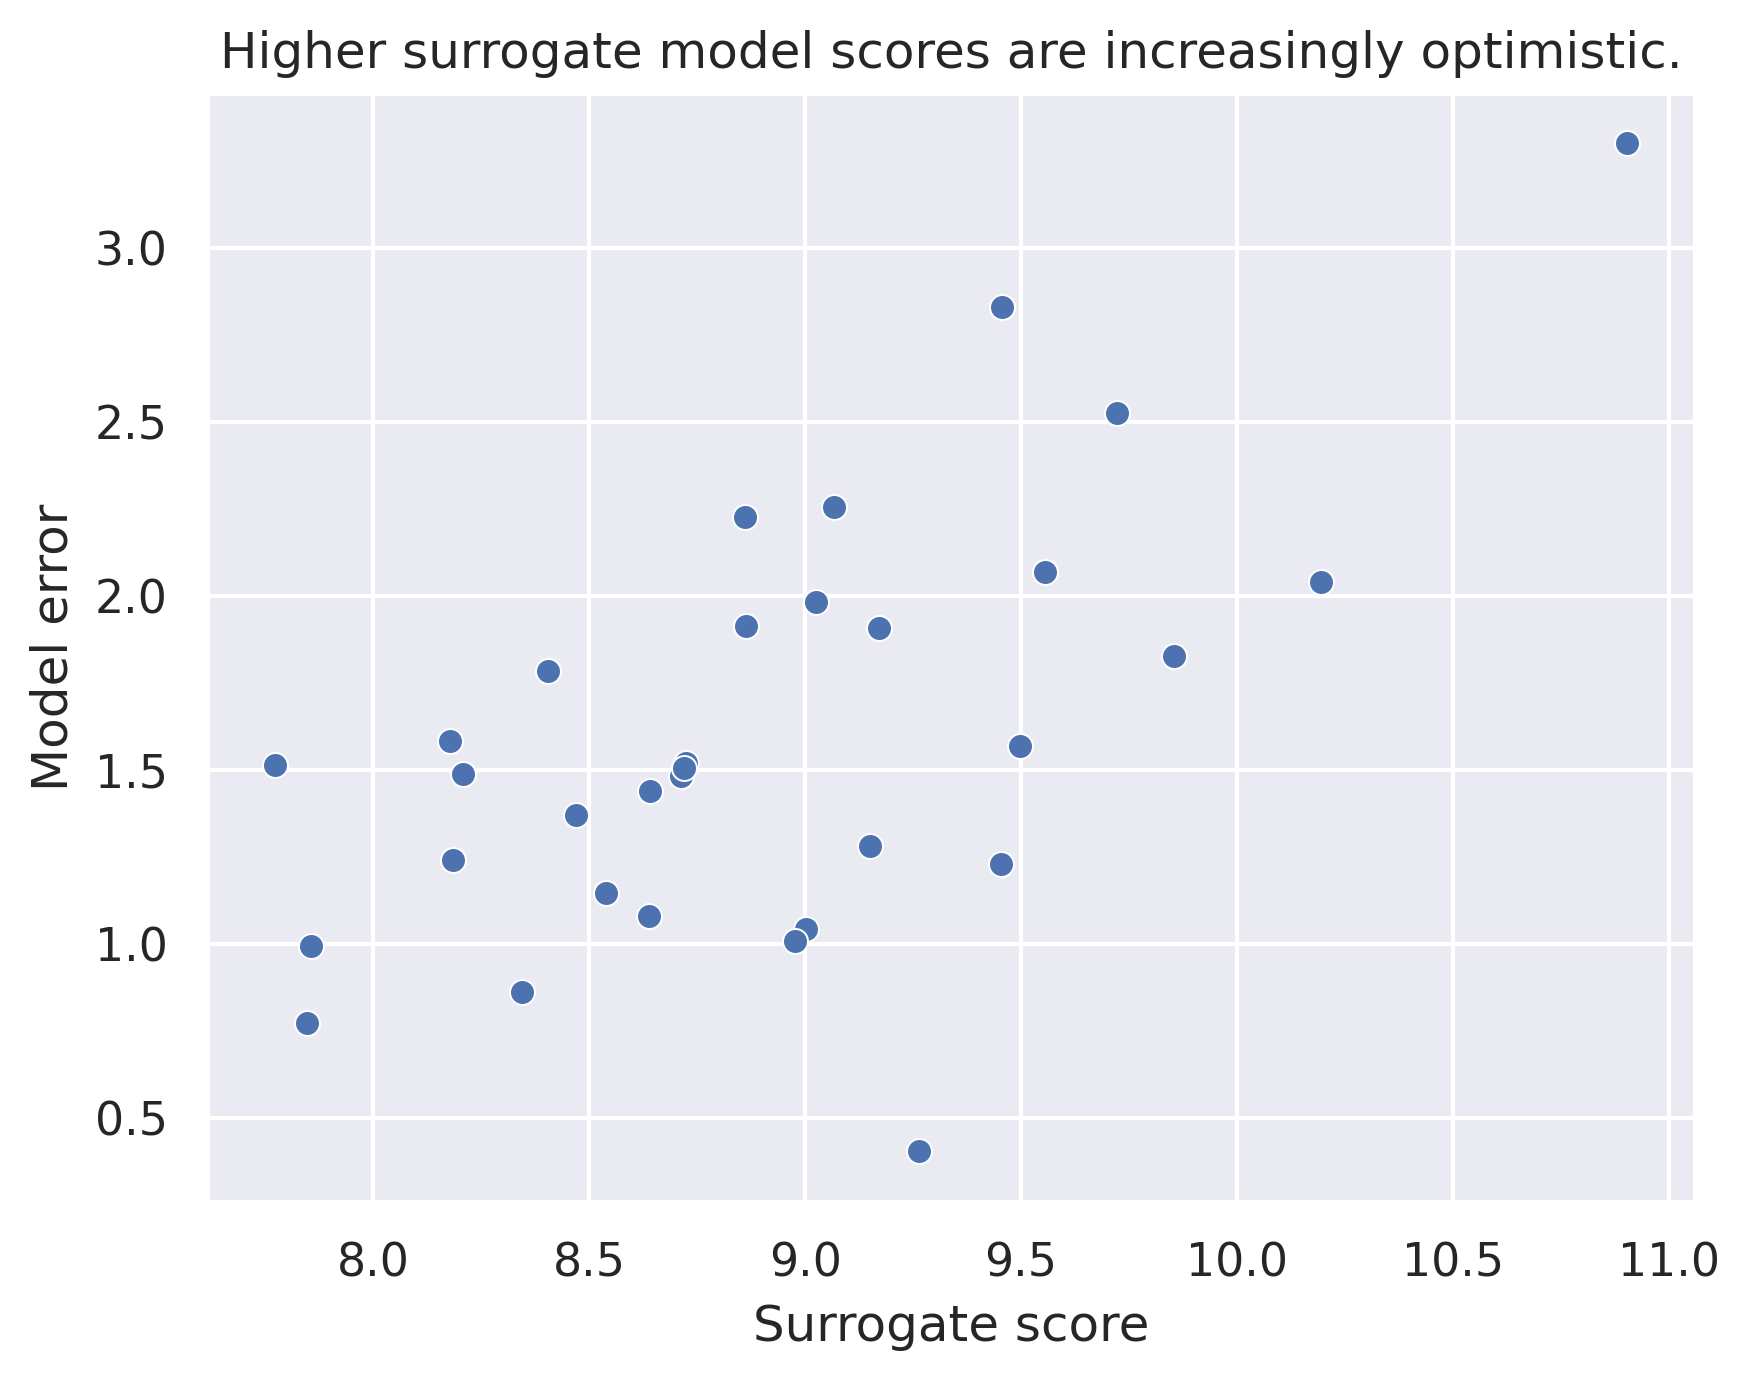

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
plt.figure(dpi=300)
sns.scatterplot(x=noisy, y=noisy-actual)
plt.title('Higher surrogate model scores are increasingly optimistic.')
plt.xlabel('Surrogate score')
plt.ylabel('Model error')

In [12]:
from scipy.stats import pearsonr

pearsonr(noisy, (noisy-actual))

PearsonRResult(statistic=0.6103236733967792, pvalue=0.00020792238284734118)

In [14]:
import numpy as np

# get noisy and actual from scored molecules
noisy_scored = observations.scored.annotations['Noisy ABL1 pIC50'].tolist()
actual_scored = [drug_env.assays['Noisy ABL1 pIC50'].oracle.cache[obs.smiles] for obs in observations.scored]

# get noisy and actual from tested molecules
noisy_tested = observations.tested.annotations['Noisy ABL1 pIC50'].tolist()
actual_tested = [drug_env.assays['Noisy ABL1 pIC50'].oracle.cache[obs.smiles] for obs in observations.tested]

# combine them
noisy = np.concatenate([noisy_scored, noisy_tested])
actual = np.concatenate([actual_scored, actual_tested])

# remove nan
noisy = noisy[~np.isnan(noisy)]
actual = actual[~np.isnan(actual)]

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Model error')

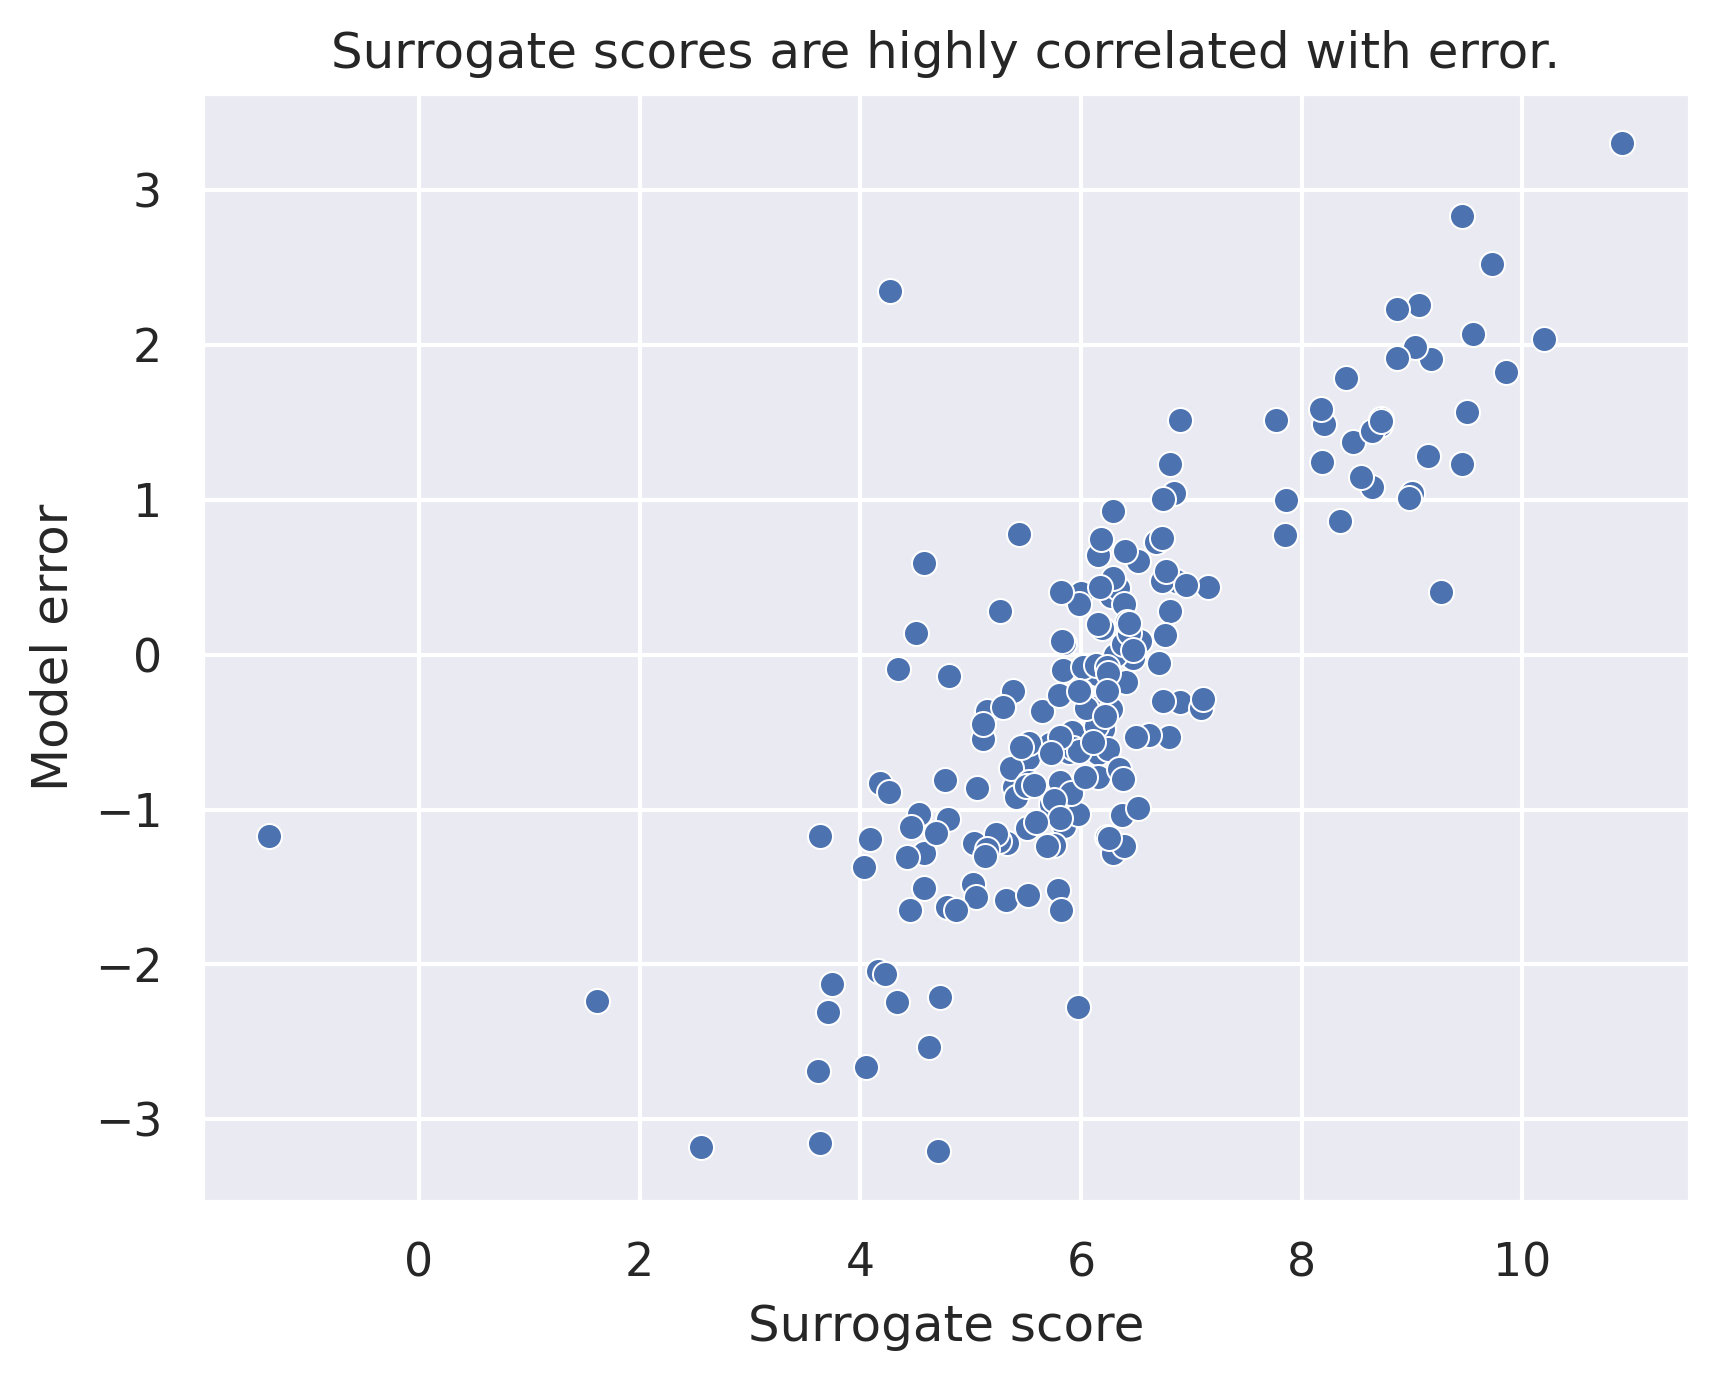

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
plt.figure(dpi=300)
sns.scatterplot(x=noisy, y=noisy-actual)
plt.title('Surrogate scores are highly correlated with error.')
plt.xlabel('Surrogate score')
plt.ylabel('Model error')

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Model error')

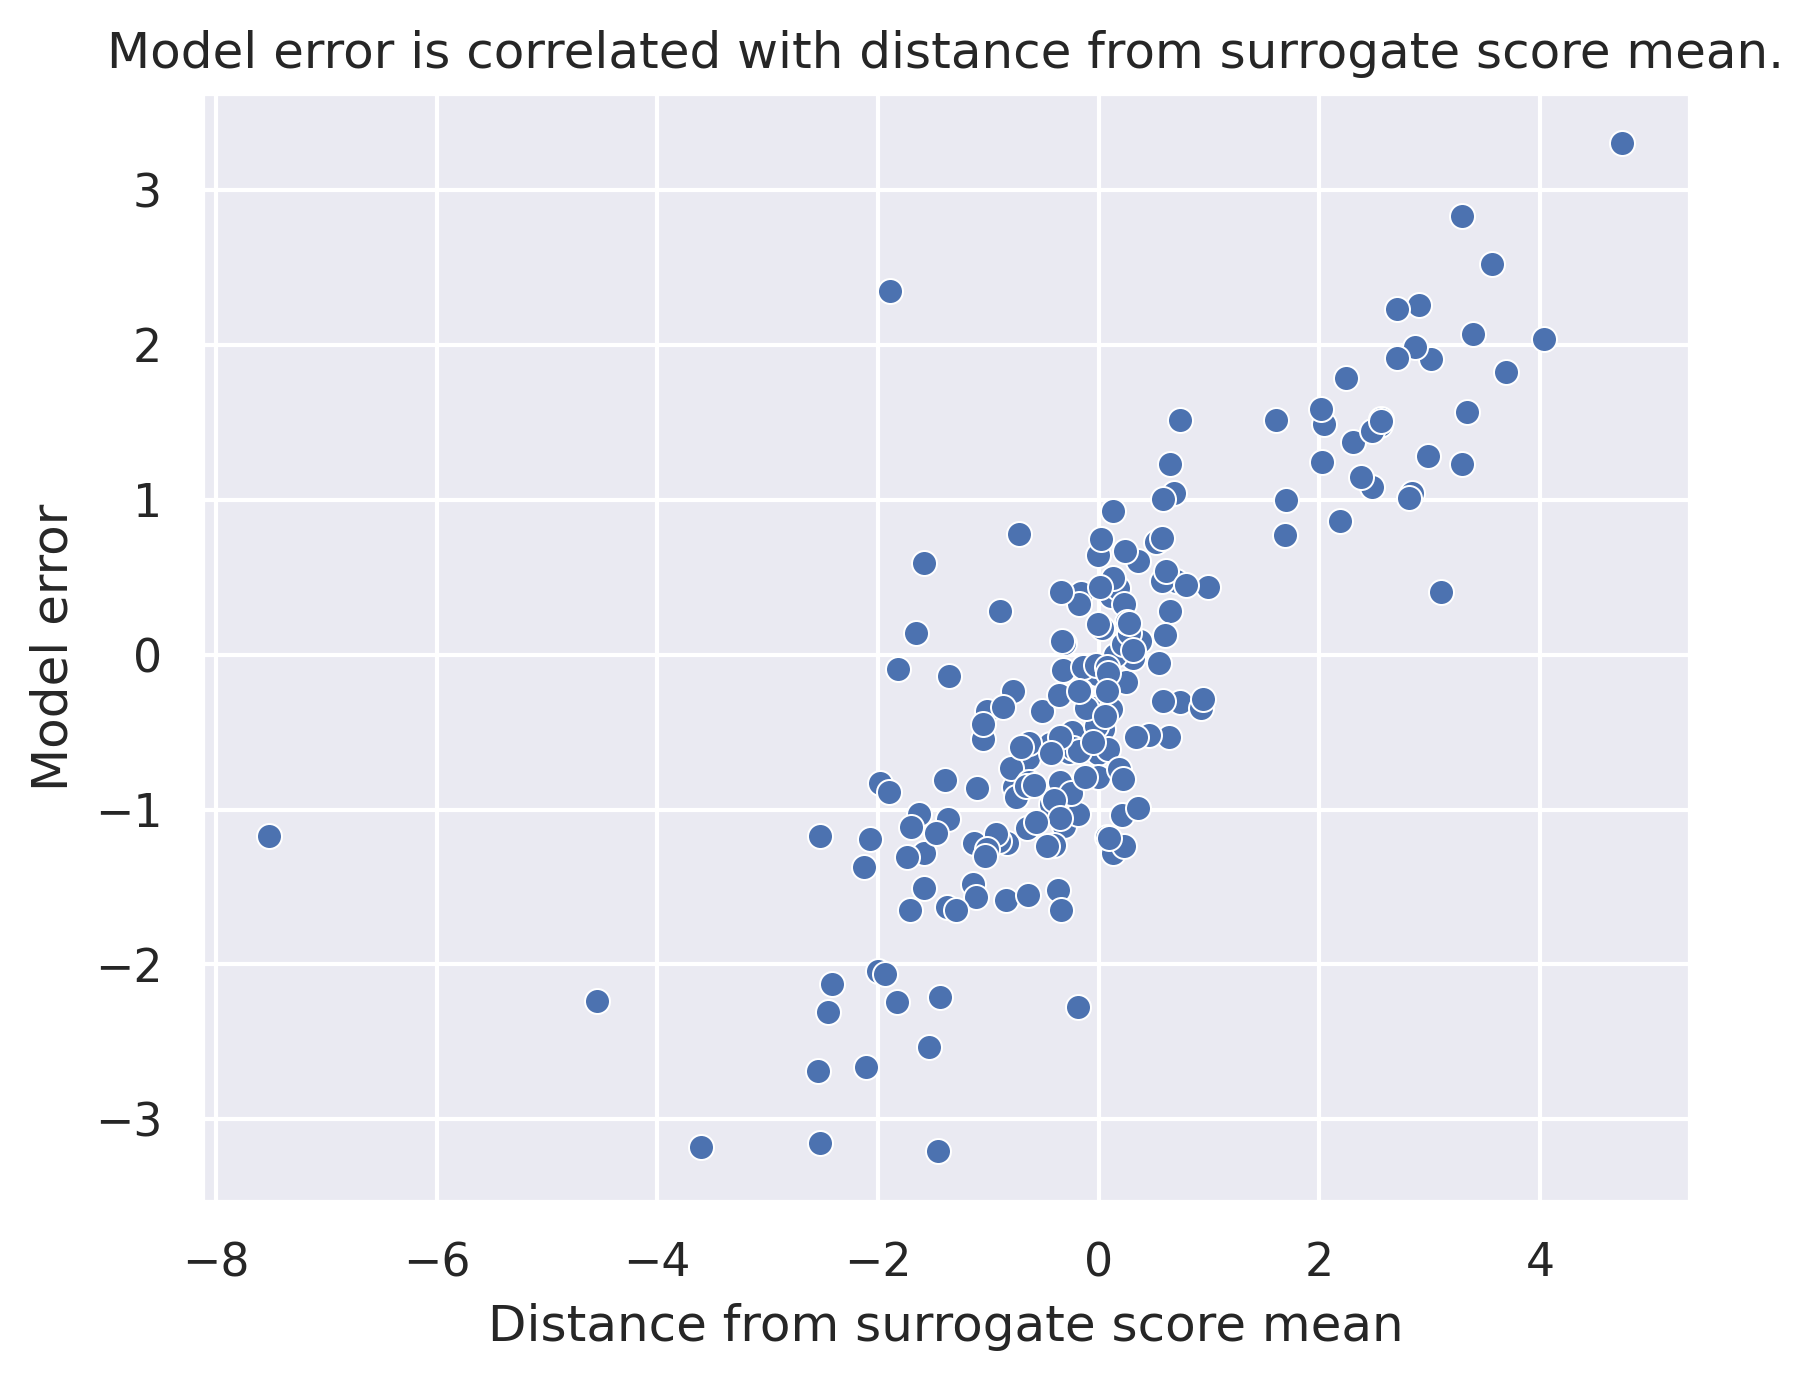

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
plt.figure(dpi=300)

distance_from_mean = (noisy - noisy.mean())
model_error = noisy - actual

sns.scatterplot(x=distance_from_mean, y=model_error)
plt.title('Model error is correlated with distance from surrogate score mean.')
plt.xlabel('Distance from surrogate score mean')
plt.ylabel('Model error')

In [17]:
from scipy.stats import pearsonr

pearsonr(distance_from_mean, model_error)

PearsonRResult(statistic=0.794011825781475, pvalue=6.155592630750268e-43)

In [36]:
# drug_env.utility_function(drug_env.library, use_precomputed=True, method='average', adjust=True)

In [117]:
self = drug_env.utility_function
input = drug_env.library

# Get actual data
actuals = input.annotations.reindex(columns=self.oracle_names)

# Get surrogate data
surrogates = actuals.add_prefix('Noisy ').columns
surrogates = input.annotations.reindex(columns=surrogates)
surrogates.columns = surrogates.columns.str.removeprefix('Noisy ')

In [120]:
for column in actuals:
    
    isna = actuals.isna().any(axis=1)
    actuals_subset = actuals[column][~isna]

    surrogates_column = surrogates[column]
    surrogates_column = sm.add_constant(surrogates_column)
    surrogates_subset = surrogates_column[~isna]

    regressor = OLS(actuals_subset, surrogates_subset).fit()
    surrogates[column] = regressor.predict(surrogates_column)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

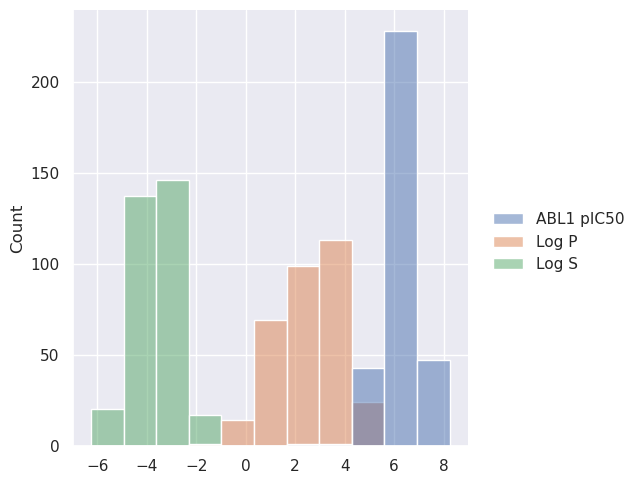

In [122]:
import seaborn as sns

sns.displot(surrogates)

In [30]:
import pandas as pd
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

distance_from_mean = (noisy - noisy.mean())
model_error = noisy - actual

exog = pd.DataFrame({'predicted value': noisy})
exog = sm.add_constant(exog)
endog = pd.DataFrame({'actual': actual})

ols = OLS(endog, exog)
results = ols.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 actual   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     149.3
Date:                Mon, 15 Apr 2024   Prob (F-statistic):           1.04e-25
Time:                        21:57:35   Log-Likelihood:                -212.23
No. Observations:                 192   AIC:                             428.5
Df Residuals:                     190   BIC:                             435.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.9028      0.211     18.526      0.000       3.487       4.318
predicted value     0.4043      0.033     12.218      0.000       0.339       0.470
==============================================================================
Omnibus:                       57.361   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              250.173
Skew:                          -1.069   Prob(JB):                     4.74e-55
Kurtosis:                       8.167   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
import pandas as pd
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

exog = pd.DataFrame({'surrogate score': noisy})
exog = sm.add_constant(exog)
endog = pd.DataFrame({'model error': preds-actual})

ols = OLS(endog, exog)
results = ols.fit()
results.summary()

NameError: name 'preds' is not defined

Text(0.5, 1.0, 'OLS-corrected surrogate scores are better calibrated')

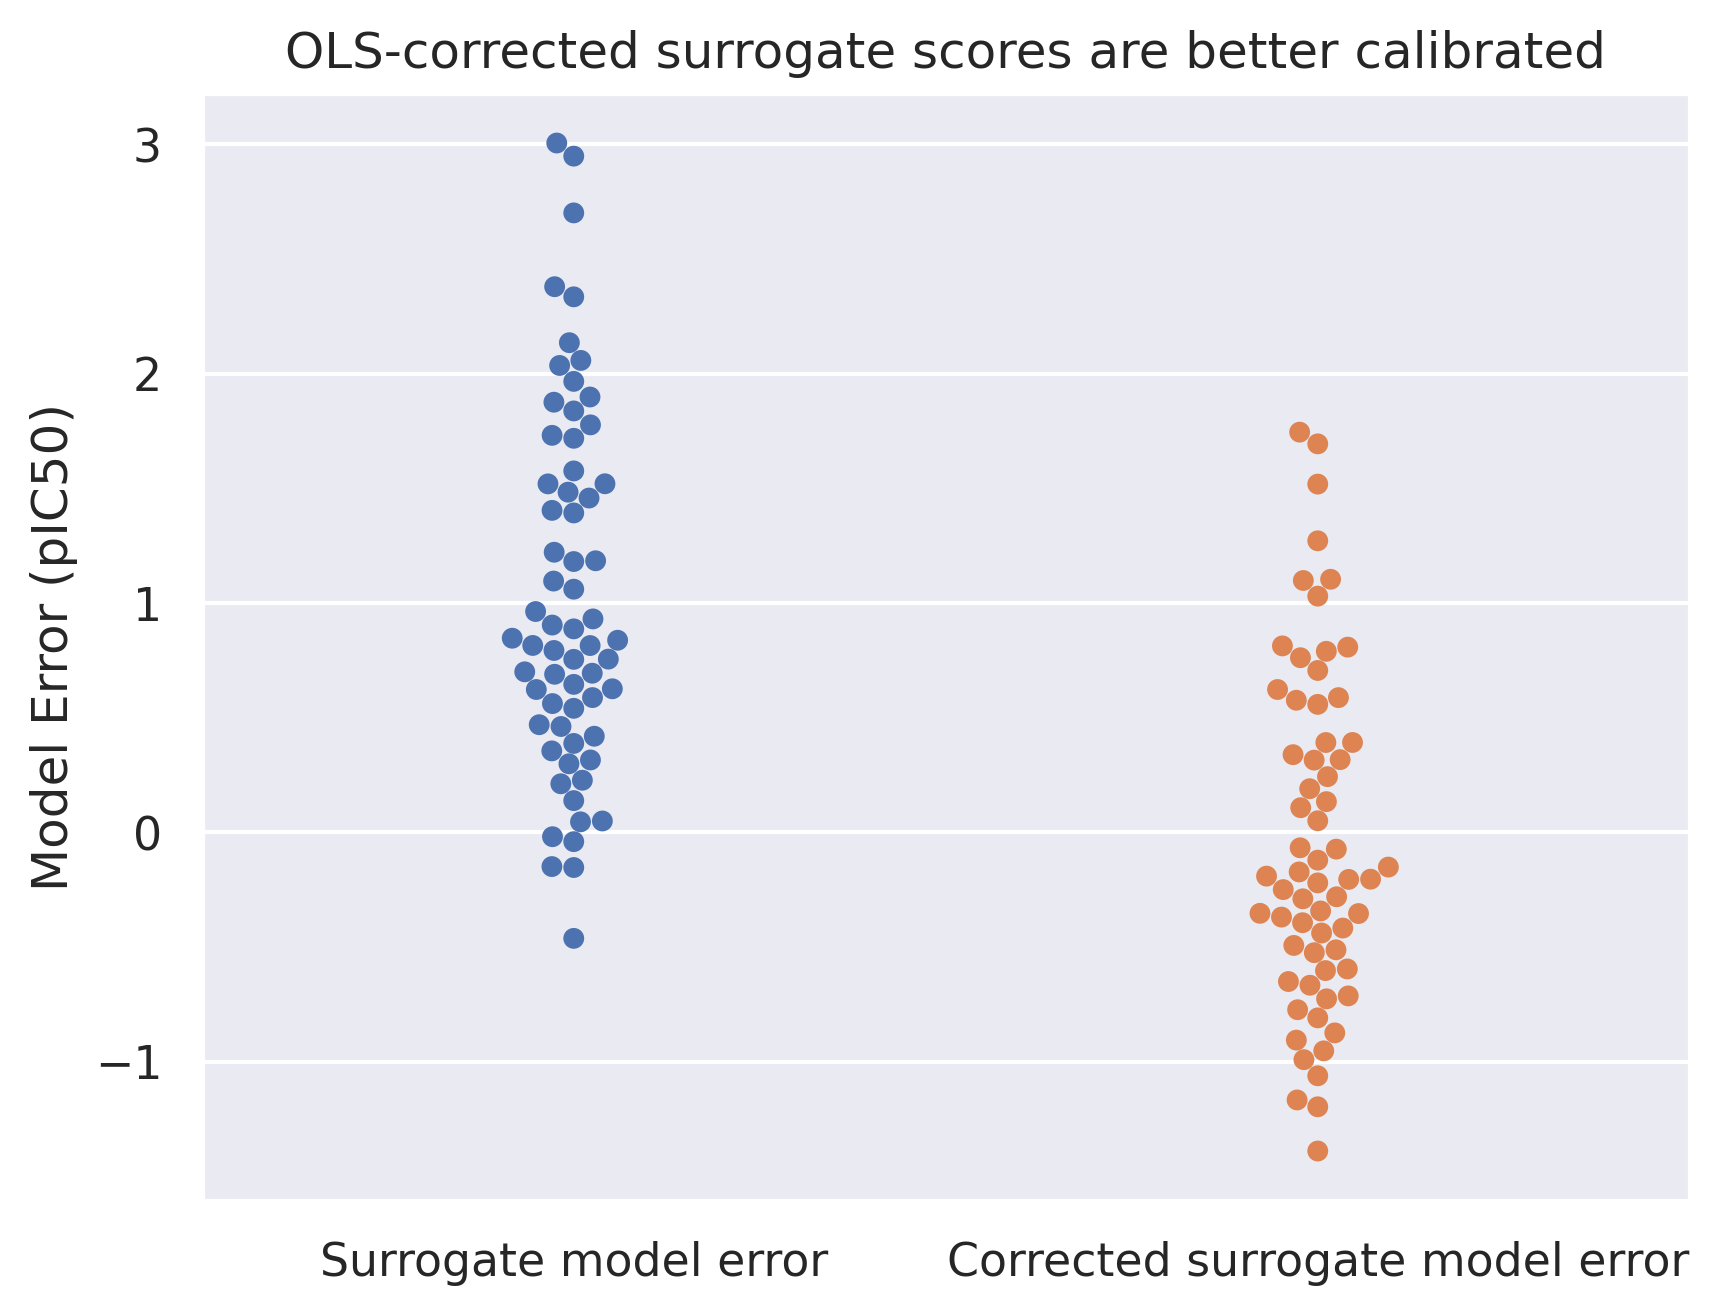

In [318]:
plt.figure(dpi=300)

df = pd.DataFrame({'Surrogate model error': noisy-actual, 'Corrected surrogate model error': preds-actual})
sns.swarmplot(df)
plt.ylabel('Model Error (pIC50)')

plt.title('OLS-corrected surrogate scores are better calibrated')

Text(0, 0.5, 'OLS-corrected surrogate scores (pIC50)')

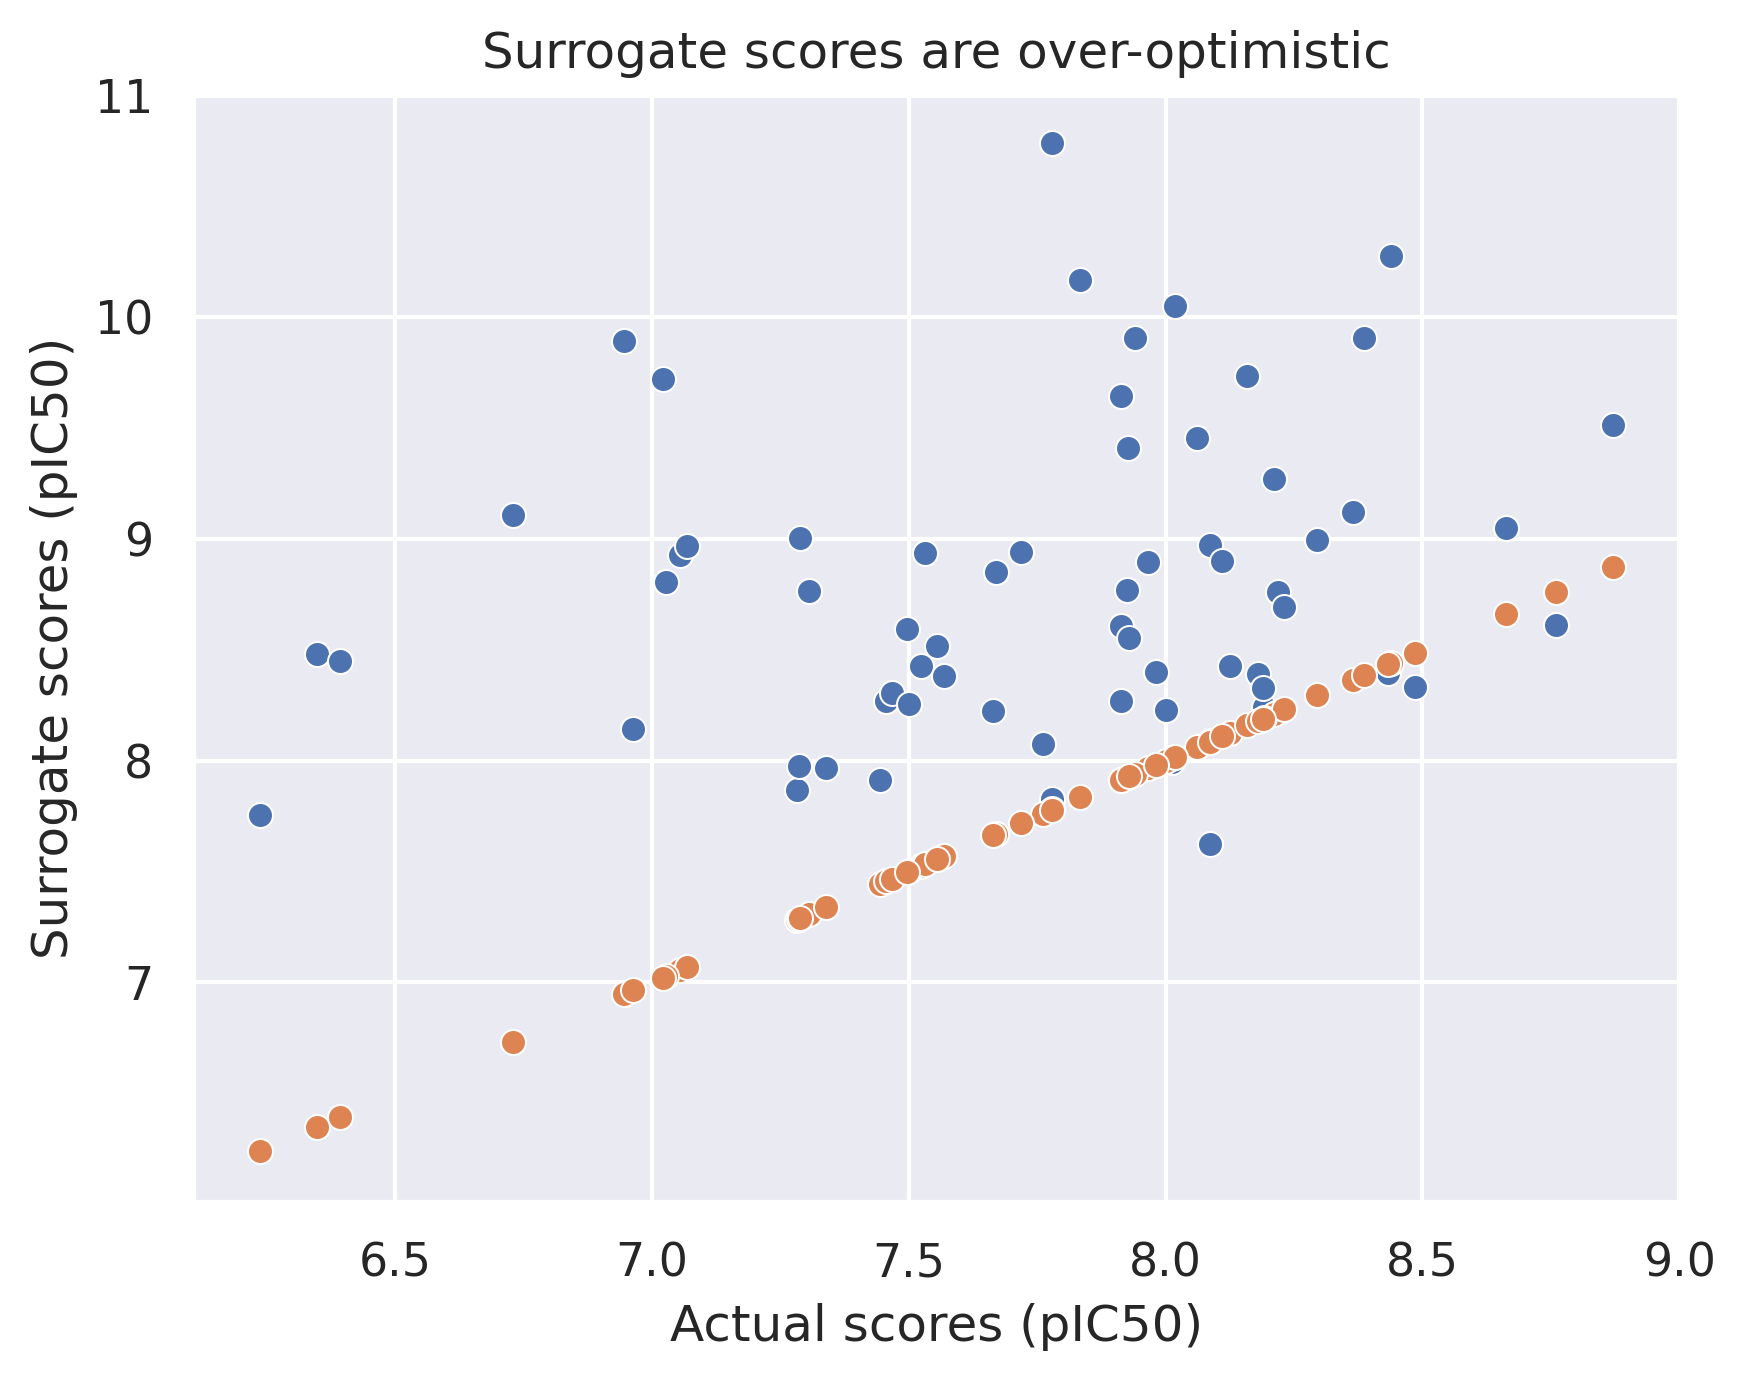

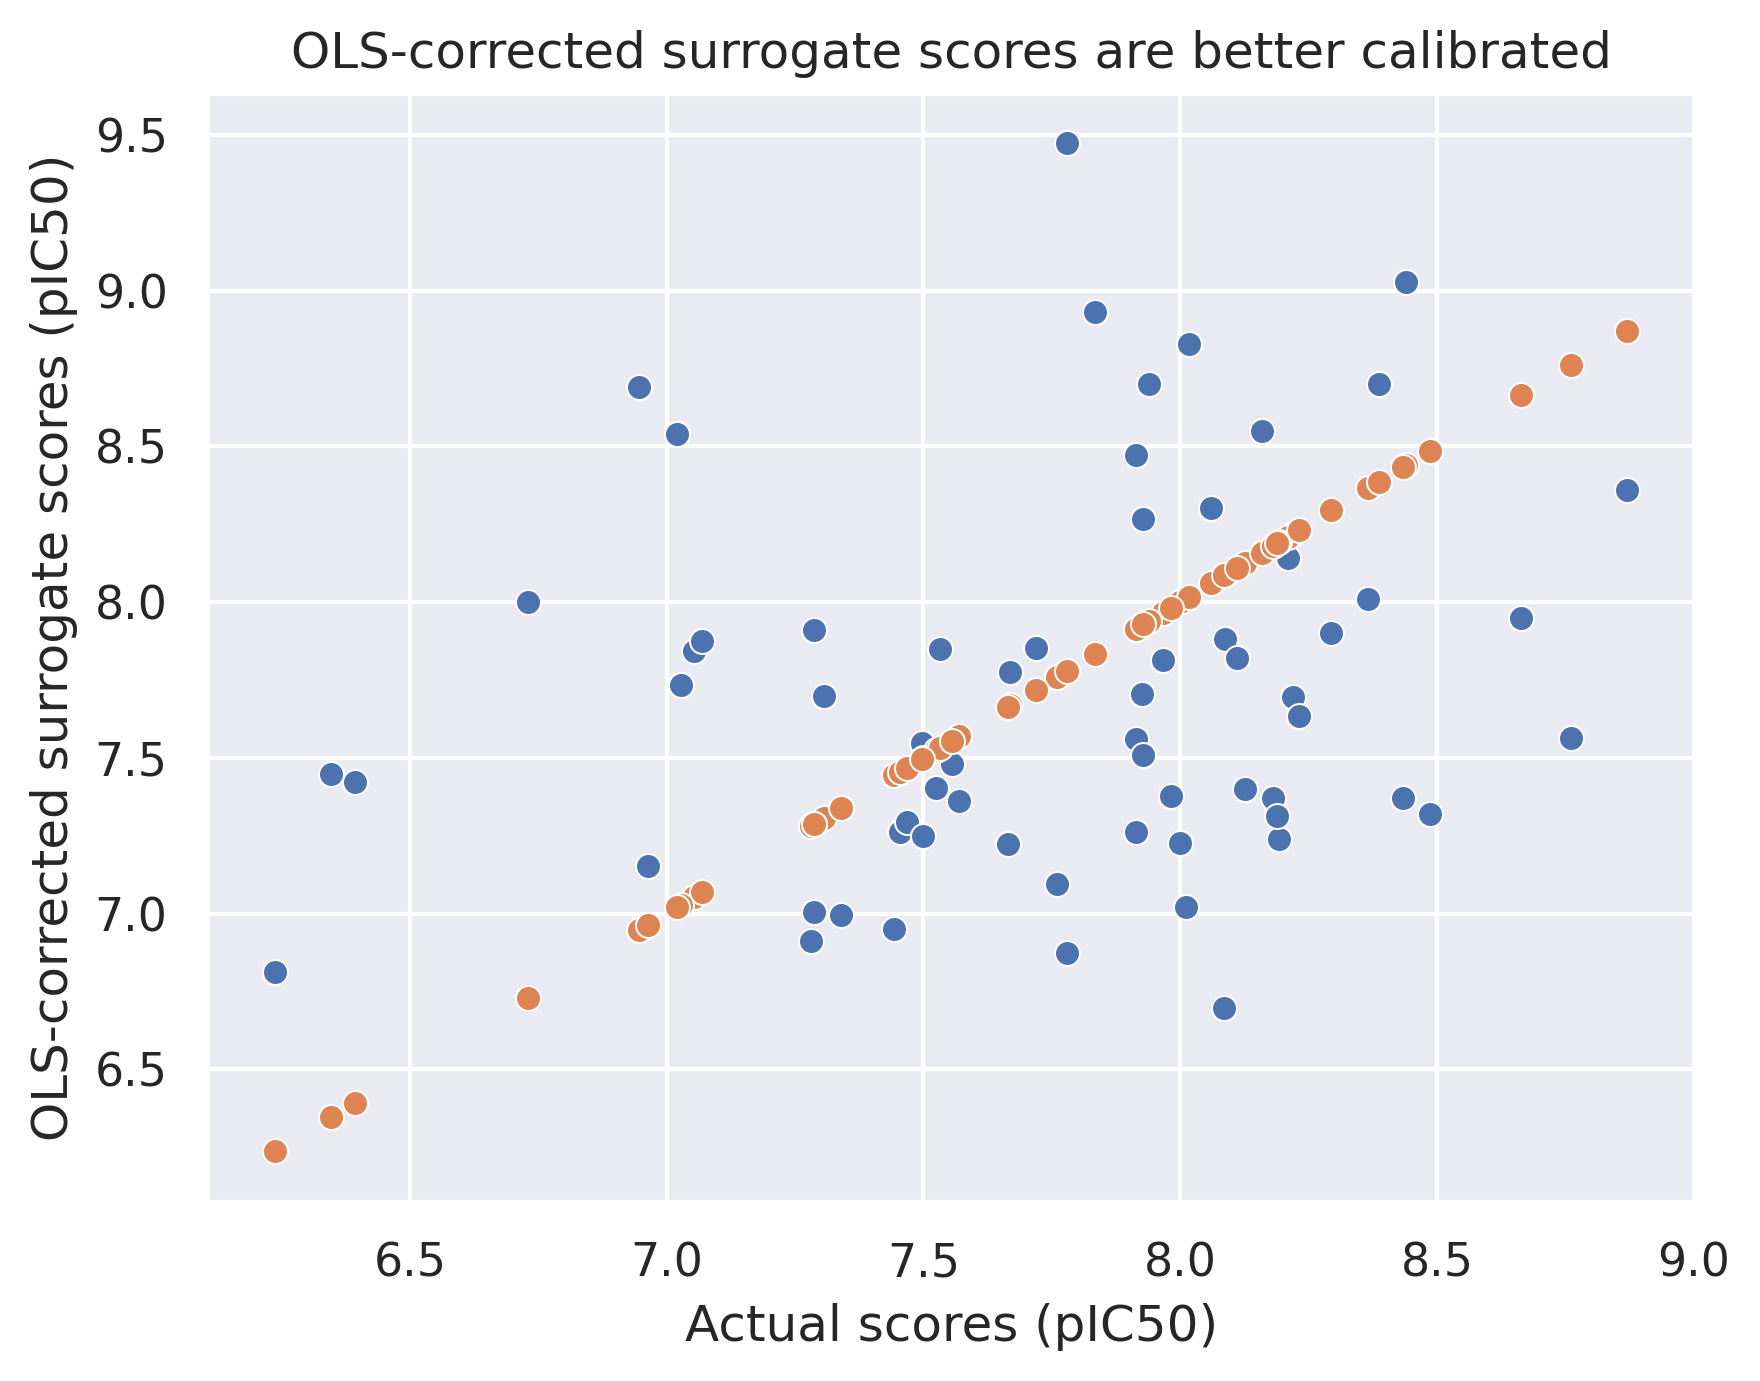

In [337]:
plt.figure(dpi=300)
sns.scatterplot(x=actual, y=noisy)
sns.scatterplot(x=actual, y=actual)
plt.title('Surrogate scores are over-optimistic')
plt.xlabel('Actual scores (pIC50)')
plt.ylabel('Surrogate scores (pIC50)')

plt.figure(dpi=300)
sns.scatterplot(x=actual, y=preds)
sns.scatterplot(x=actual, y=actual)
plt.title('OLS-corrected surrogate scores are better calibrated')
plt.xlabel('Actual scores (pIC50)')
plt.ylabel('OLS-corrected surrogate scores (pIC50)')

Let's look at the number of "true" top *k* molecules that show up in the top *k* by prediction.

(0.0, 31.0)

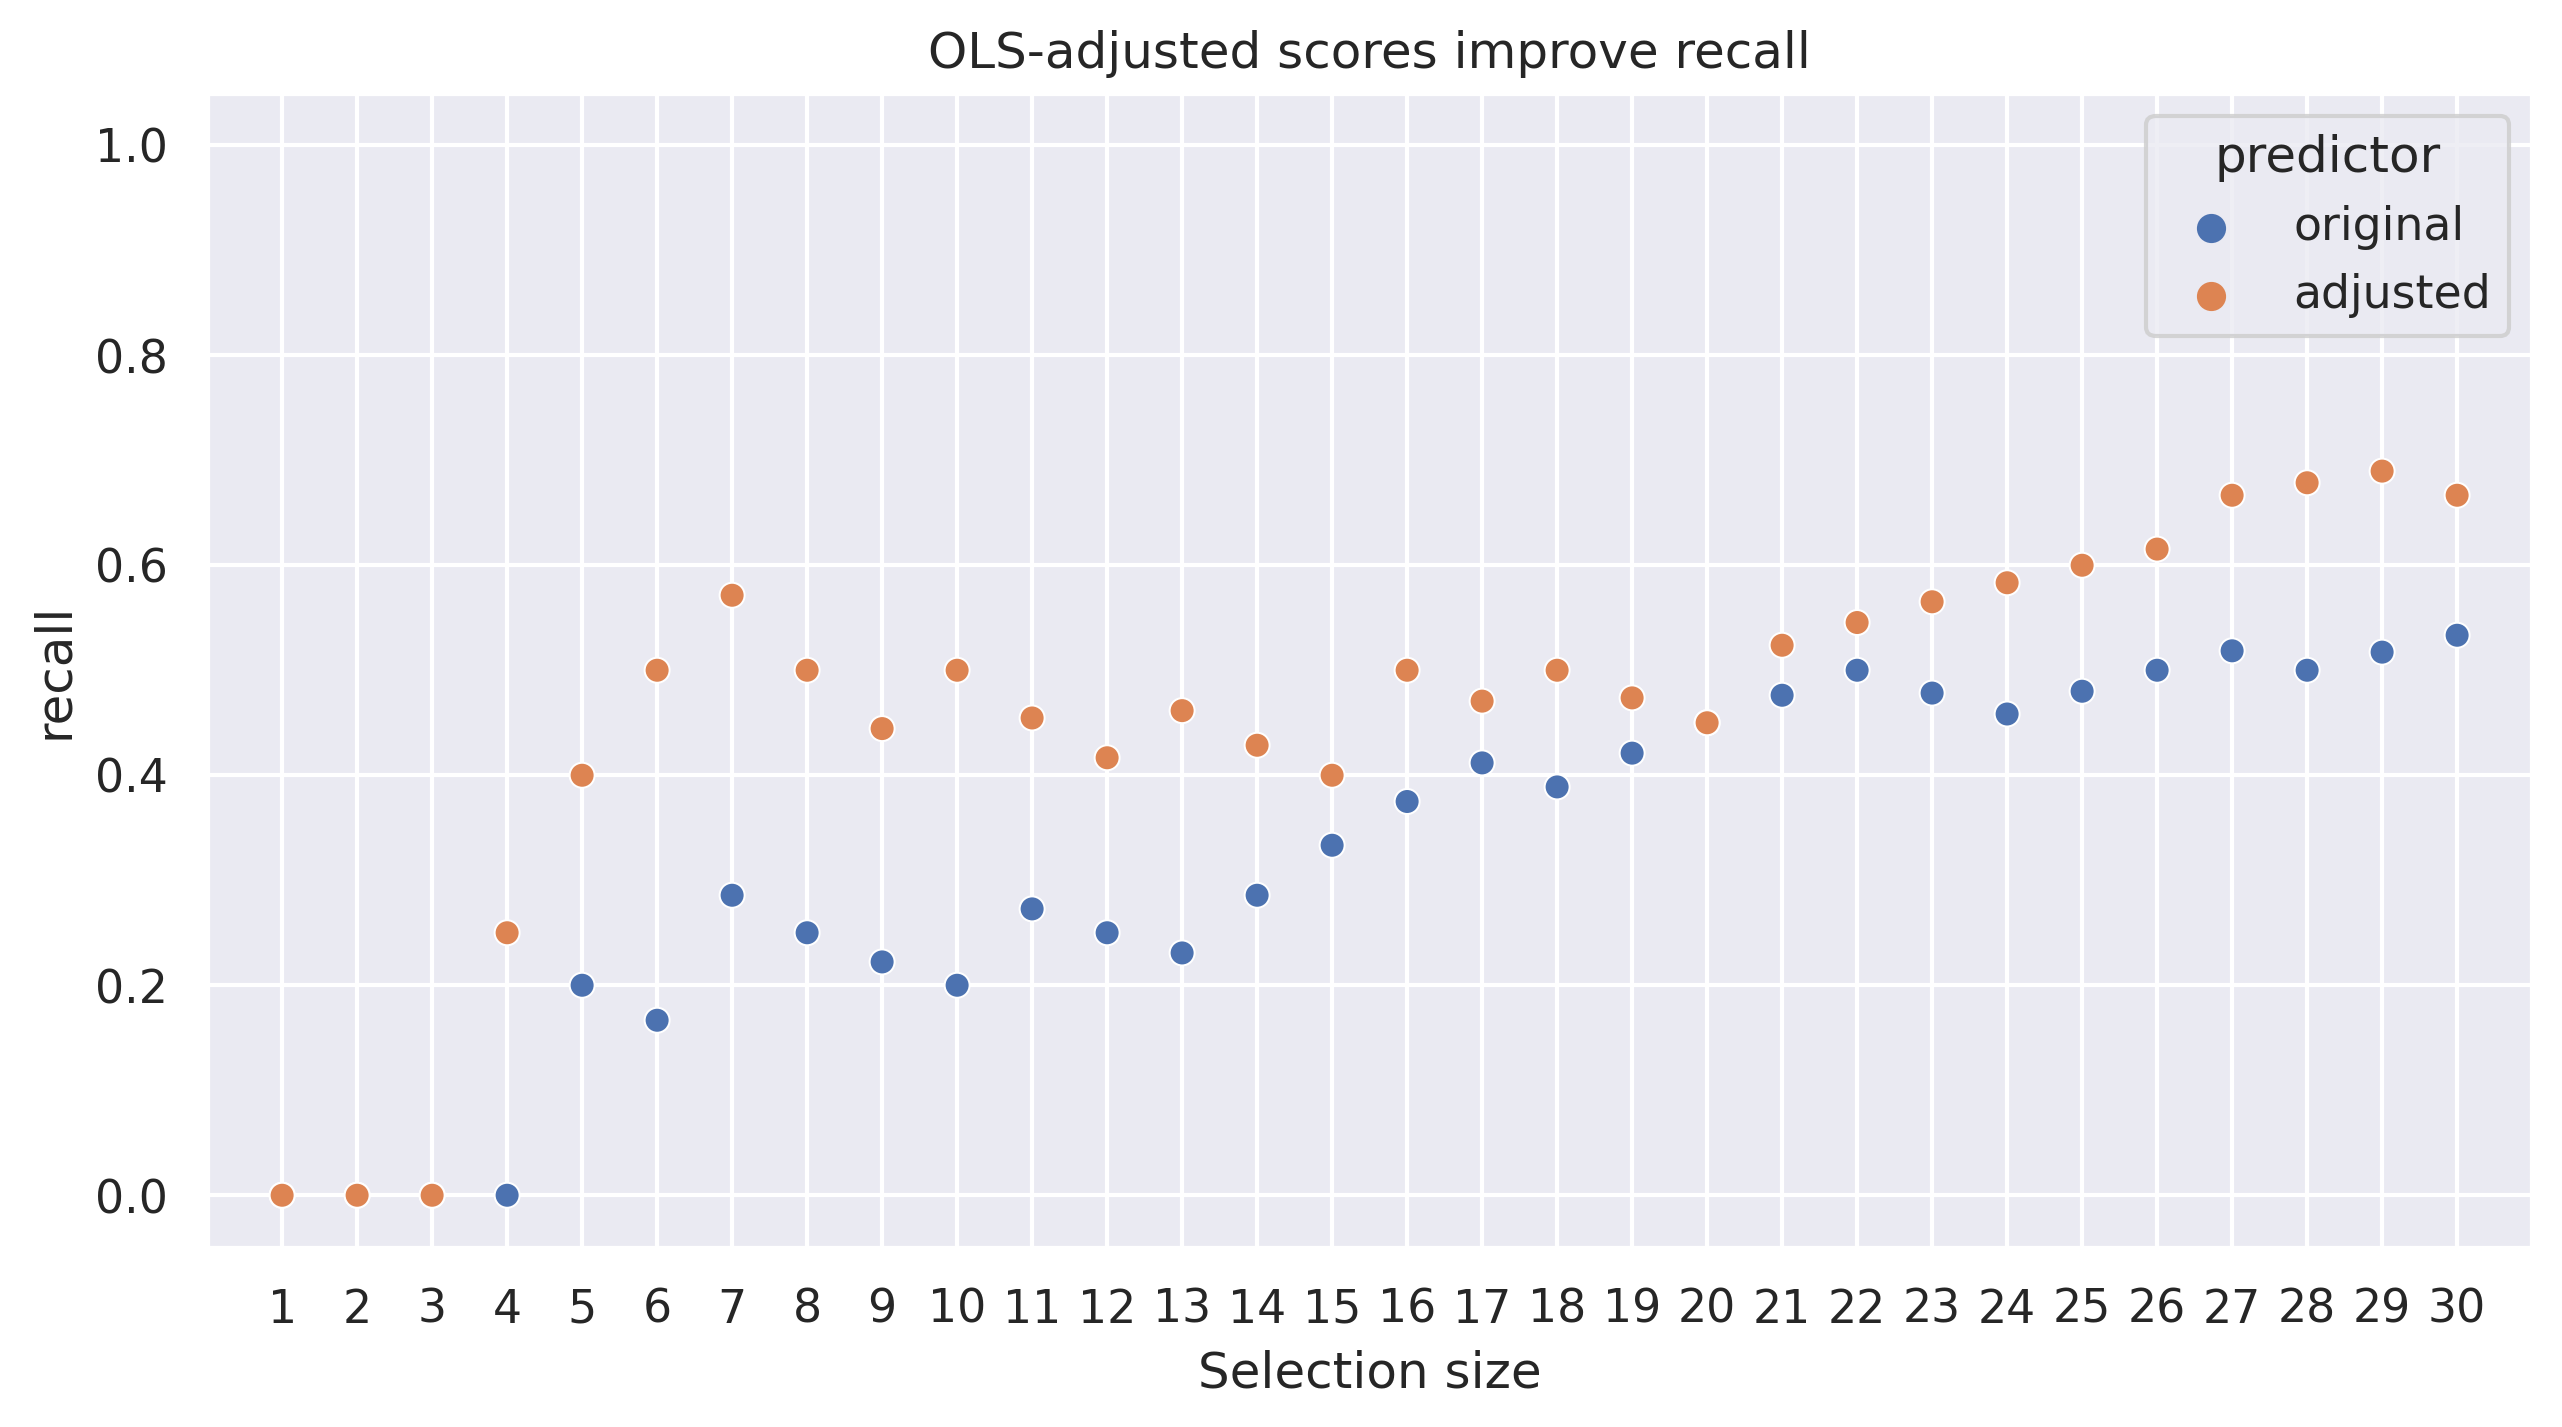

In [496]:
def merge_ranks(actual, predictor):
    ranks = []
    for rank in np.argsort([*actual, *predictor]):
        if rank > len(actual):
            ranks.append(rank - len(actual))
        else:
            ranks.append(rank)
    return ranks

size = 31
records = []
predictors = [('original', noisy), ('adjusted', preds)]
for predictor_name, predictor in predictors:
    pred_sort = merge_ranks(actual, predictor)
    actual_sort = actual.argsort()
    for k in range(1, size):
        pred_best = pred_sort[-k:]
        actual_best = actual_sort[-k:]
        recall = len(np.intersect1d(pred_best, actual_best)) / k
        records.append({'predictor': predictor_name, 'recall': recall, 'Selection size': k})

df = pd.DataFrame(records)

plt.figure(dpi=300, figsize=(10, 5))
sns.scatterplot(df, x='Selection size', y='recall', hue='predictor')
plt.xticks(range(1, size))
plt.title('OLS-adjusted scores improve recall')
plt.ylim(-0.05, 1.05)
plt.xlim(0, size)

Let's look at the average rank of the top *k* molecules chosen by different original vs. OLS-adjusted predictors.

(0.0, 31.0)

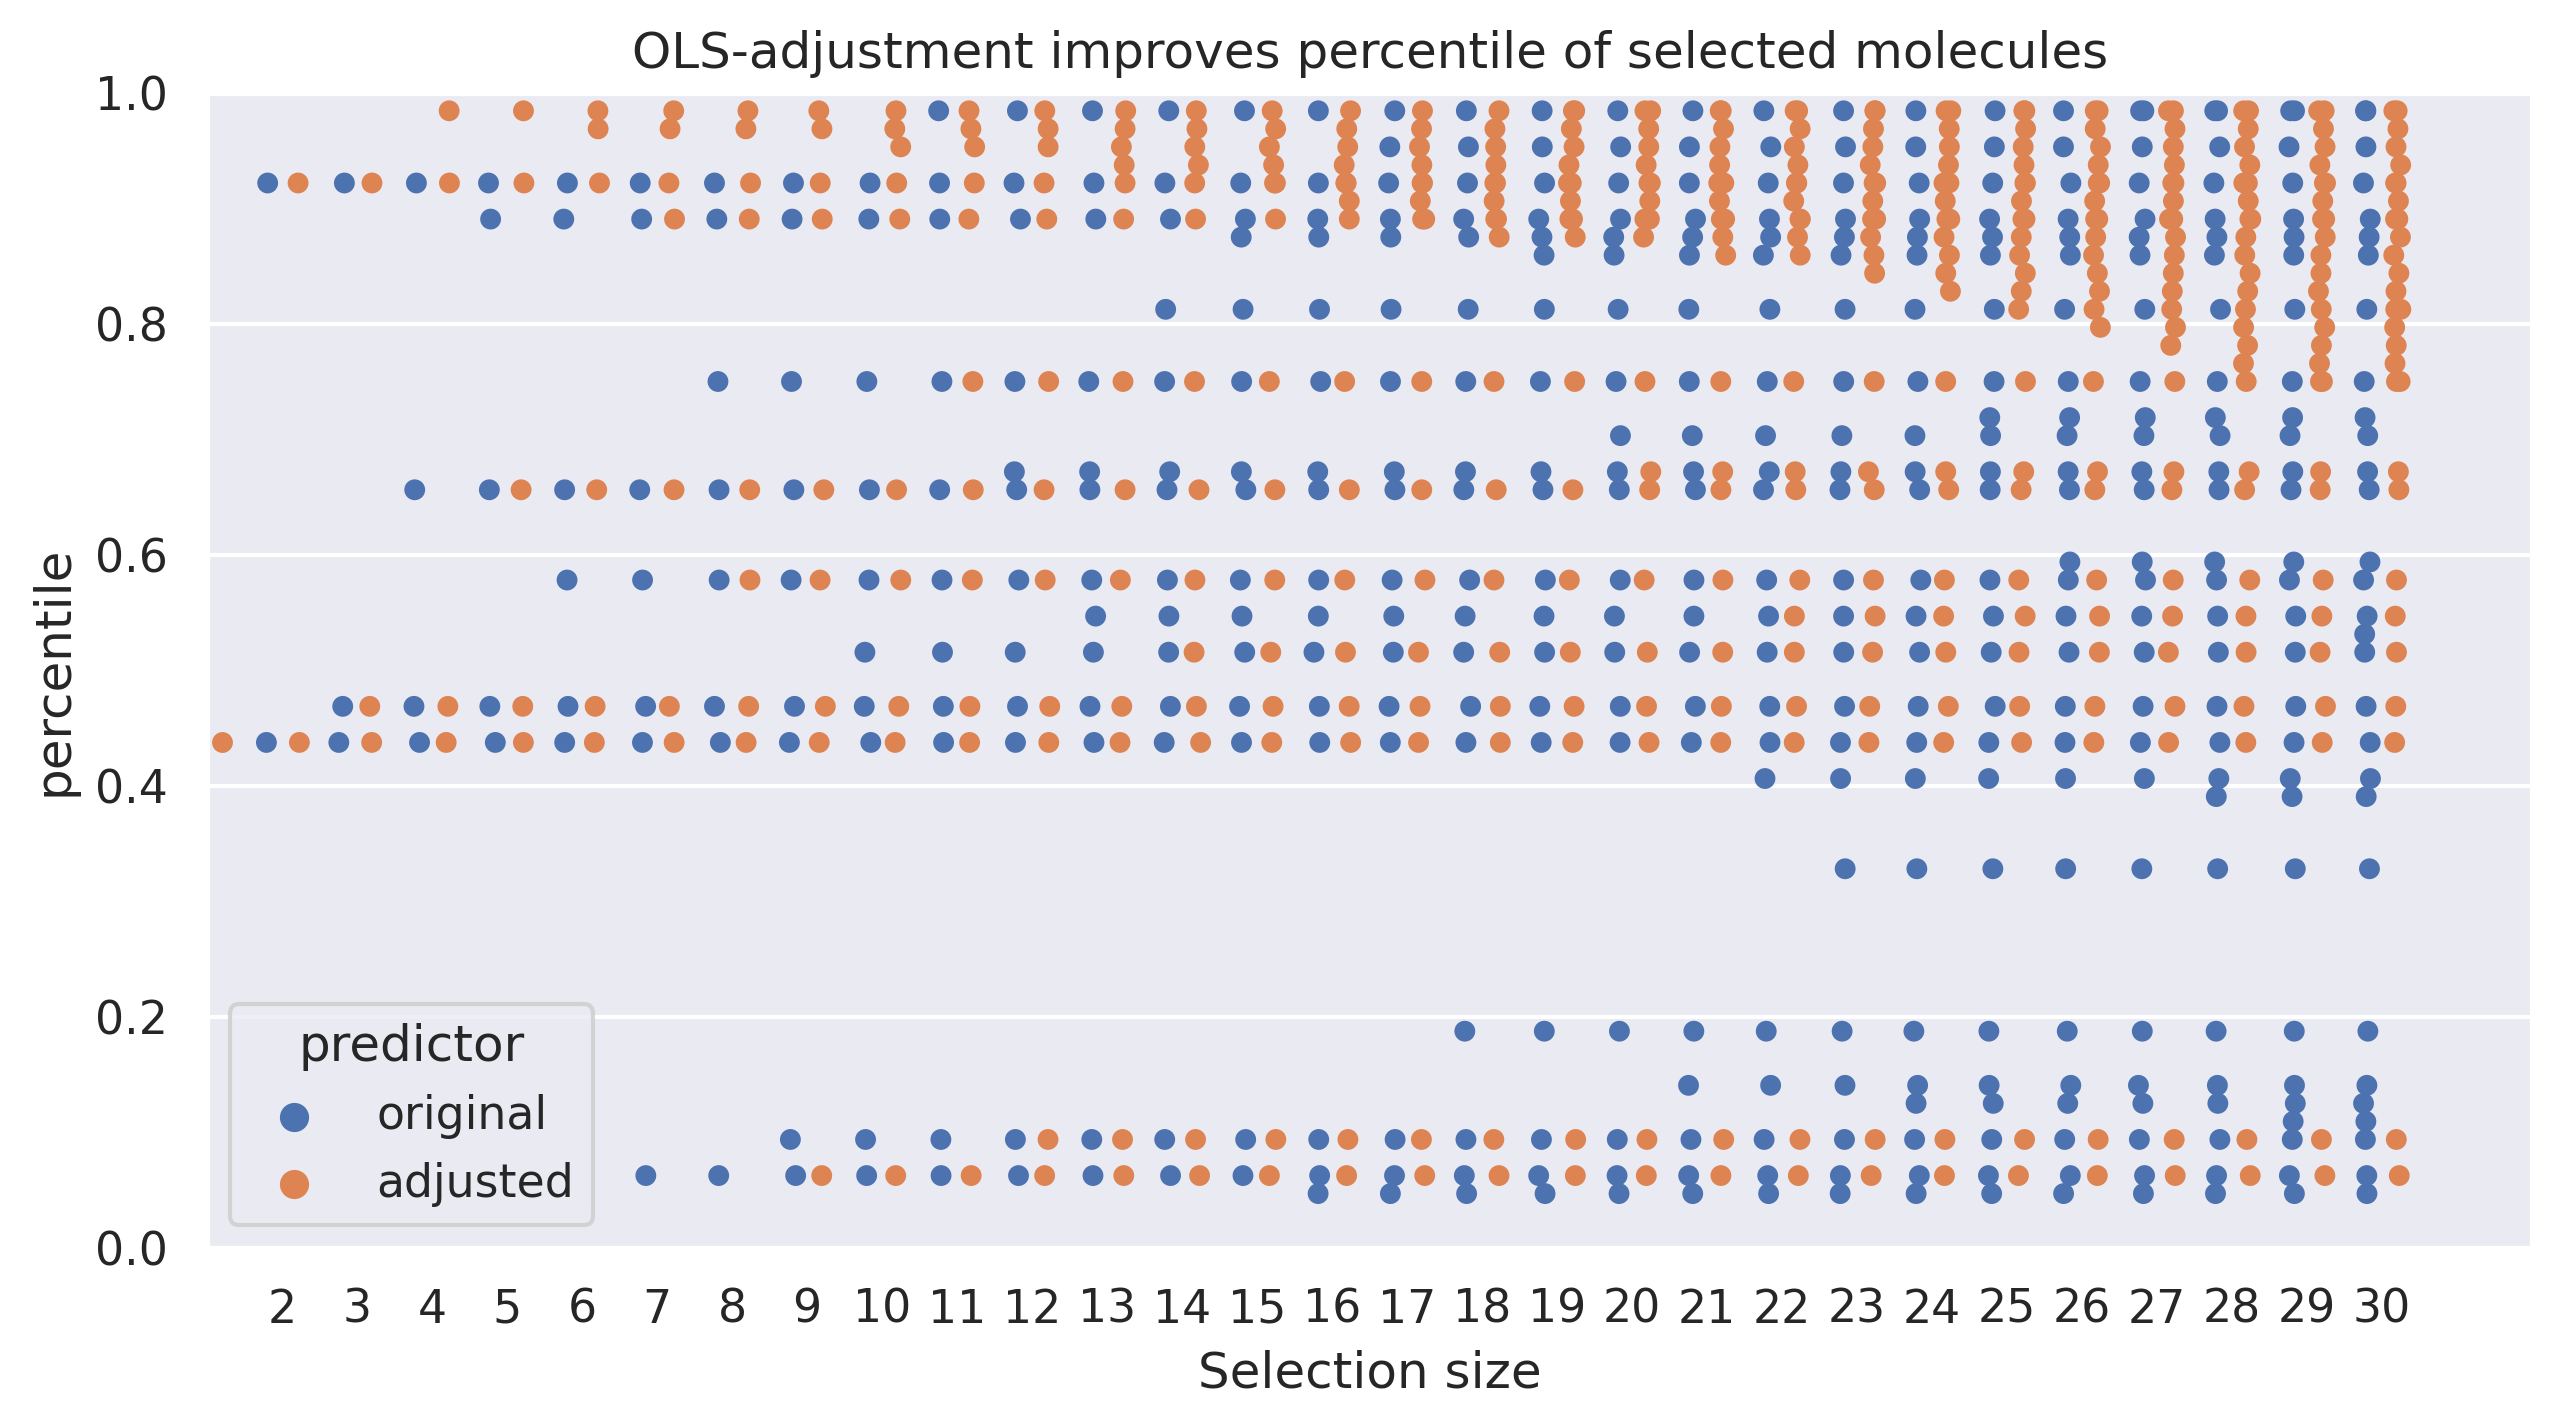

In [500]:
def merge_ranks(actual, predictor):
    ranks = []
    for rank in np.argsort([*actual, *predictor]):
        if rank > len(actual):
            ranks.append(rank - len(actual))
        else:
            ranks.append(rank)
    return ranks

size = 31
records = []
predictors = [('original', noisy), ('adjusted', preds)]
for predictor_name, predictor in predictors:
    pred_sort = merge_ranks(actual, predictor)
    actual_sort = actual.argsort()
    
    for k in range(1, size):
        pred_best = pred_sort[-k:]
        pred_ranks = actual_sort.argsort()[pred_best]
        percentiles = pred_ranks / len(actual)
        
        for percentile in percentiles:
            record = {'predictor': predictor_name, 'percentile': percentile, 'Selection size': k}
            records.append(record)

df = pd.DataFrame(records)

plt.figure(dpi=300, figsize=(10, 5))
sns.stripplot(df, x='Selection size', y='percentile', hue='predictor', dodge=True)
plt.xticks(range(1, size))
plt.title('OLS-adjustment improves percentile of selected molecules')
plt.ylim(0.0, 1)
plt.xlim(0, size)